# Frame Semantic Transformer: Swedish Training

This notebook trains and evaluates a Swedish SRL model based on the [Frame Semantic Transformer library](https://github.com/chanind/frame-semantic-transformer)

In [1]:
import torch
print(f'built: {torch.backends.cuda.is_built()}')
print(f'CUDNN version: {torch.backends.cudnn.version()}')
torch.cuda.is_available()
# torch.cuda.device_count()

# torch.__version__
# # verify that your graphics card and driver both support the required CUDA version 
# torch.zeros(1).cuda()

# !nvcc --version

built: True
CUDNN version: 8500


True

In [2]:
!nvidia-smi

import os
print(f"num cpus: {os.cpu_count()}")

Wed Jun 14 03:12:33 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 516.01       Driver Version: 516.01       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:07:00.0  On |                  N/A |
|  0%   48C    P8    11W / 166W |    348MiB /  8192MiB |      4%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# Clone the git repo and switch to the multilingual-training-refactor branch
# NOTE: Once this code is merged, you can just do a normal pip install

# !rm -rf /frame-semantic-transformer
# !git clone https://github.com/chanind/frame-semantic-transformer.git
# !git checkout multilingual-training-refactor

In [4]:
import sys
sys.path.append('./frame-semantic-transformer')
%cd ./frame-semantic-transformer

c:\Users\lucyy\Documents\ADS_thesis\toGithub\Model1\frame-semantic-transformer


In [4]:
# check package version
# import transformers
# transformers.__version__

'4.24.0'

In [3]:
# !pip install pytorch_lightning sentencepiece
# Download swedish Framenet XML
# !wget https://svn.spraakdata.gu.se/sb-arkiv/pub/lmf/swefn/swefn.xml

--2023-02-24 11:15:07--  https://svn.spraakdata.gu.se/sb-arkiv/pub/lmf/swefn/swefn.xml
Resolving svn.spraakdata.gu.se (svn.spraakdata.gu.se)... 130.241.135.158
Connecting to svn.spraakdata.gu.se (svn.spraakdata.gu.se)|130.241.135.158|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7342238 (7,0M) [text/xml]
Saving to: 'swefn.xml'

     0K .......... .......... .......... .......... ..........  0% 1,59M 4s
    50K .......... .......... .......... .......... ..........  1% 3,16M 3s
   100K .......... .......... .......... .......... ..........  2%  109M 2s
   150K .......... .......... .......... .......... ..........  2% 3,27M 2s
   200K .......... .......... .......... .......... ..........  3%  121M 2s
   250K .......... .......... .......... .......... ..........  4%  113M 1s
   300K .......... .......... .......... .......... ..........  4%  118M 1s
   350K .......... .......... .......... .......... ..........  5% 96,1M 1s
   400K .......... .......... ....

In [5]:
# Implement custom Traning and Inference loaders for the Swedish Framenet data
# This is the core step necessary to get FrameSemanticTransformer to work with different languages/framenets

import xml.etree.ElementTree as ET
import random
import re
from typing import List
from frame_semantic_transformer.data.loaders.loader import TrainingLoader, InferenceLoader
from frame_semantic_transformer.data.frame_types import Frame, FrameAnnotatedSentence, FrameAnnotation, FrameElementAnnotation
from frame_semantic_transformer.data.augmentations import (
    DataAugmentation,
    LowercaseAugmentation,
    RemoveEndPunctuationAugmentation,
)
from nltk.stem import SnowballStemmer

swedish_stemmer = SnowballStemmer("swedish")


def extract_frame(xml_frame) -> Frame:
    """
    Extract a Frame element from the Swedish XML for a frame
    """
    name = xml_frame.attrib["id"].replace('swefn--', '')
    core_elms = [
        ft.attrib["val"] for ft in xml_frame.findall(".//feat[@att='coreElement']")
    ]
    non_core_elms = [
        ft.attrib["val"]
        for ft in xml_frame.findall(".//feat[@att='peripheralElement']")
    ]
    lus = [ft.attrib["val"] for ft in xml_frame.findall(".//feat[@att='LU']")]
    # some examples have triggers outside the listed 'LU', but they are usually registerred as 'suggestionForLU'
    lus += [ft.attrib["val"] for ft in xml_frame.findall(".//feat[@att='suggestionForLU']")]

    return Frame(
        name=name,
        core_elements=core_elms,
        non_core_elements=non_core_elms,
        lexical_units=lus,
    )


def extract_example(example_xml, frame_name) -> FrameAnnotatedSentence:
    """
    Extract an annotated training sentence from a Swedish FrameNet Example XML
    NOTE: This isn't ideal since only 1 frame is tagged in each example. This may
    cause the Swedish FrameSemanticTransformer to only ever tag 1 frame per sentence.
    """
    nodes_to_extract = [n for n in example_xml]
    text = ""
    trigger_locs = []
    frame_elements = []
    while len(nodes_to_extract) > 0:
        node = nodes_to_extract.pop(0)
        # sometimes there's nodes in nodes, compound annotation in SweFN
        # in this case, push the children of this node to the front of the queue and keep going
        if len(node) > 0:
            nodes_to_extract = [n for n in node] + nodes_to_extract
        else:
            cur_index = len(text)
            if not node.text:
                continue
            node_text = re.sub(r"\s+", ' ', node.text)
            if node.attrib.get("name") == "LU":
                trigger_locs.append(cur_index)
            elif "name" in node.attrib:
                frame_elements.append(
                    FrameElementAnnotation(
                        name=node.attrib["name"],
                        start_loc=cur_index,
                        end_loc=cur_index + len(node_text),
                    )
                )
            text += node_text + " "
    text = text.strip()
    return FrameAnnotatedSentence(
        text=text,
        annotations=[
            FrameAnnotation(
                frame=frame_name,
                trigger_locs=trigger_locs,
                frame_elements=frame_elements,
            )
        ],
    )


class SwedishTrainingLoader(TrainingLoader):
    """
    Training Loader for Swedish
    This class tells FrameSemanticTransformer how to load the Swedish FrameNet training data
    """
    train_sentences: List[FrameAnnotatedSentence]
    test_sentences: List[FrameAnnotatedSentence]
    val_sentences: List[FrameAnnotatedSentence]


    def __init__(self, swedish_framenet_xml_file, test_portion=0.1, val_portion=0.1, seed=42):
        # parse annotated sentences from XML
        annotated_sentences = []
        tree = ET.parse(swedish_framenet_xml_file)
        root = tree.getroot()
        for xml_frame in root.findall(".//Sense"):
            frame = extract_frame(xml_frame)
            for child in xml_frame:
                if 'example' in child.tag:
                    annotated_sentences.append(extract_example(child, frame.name))
        # split into train/test/val 
        random.Random(seed).shuffle(annotated_sentences)
        num_test = int(test_portion * len(annotated_sentences))
        num_val = int(val_portion * len(annotated_sentences))

        self.test_sentences = annotated_sentences[0:num_test]
        self.val_sentences = annotated_sentences[num_test:num_test + num_val]
        self.train_sentences = annotated_sentences[num_test + num_val:]
    
    def load_training_data(self):
        return self.train_sentences
    
    def load_validation_data(self):
        return self.val_sentences
    
    def load_test_data(self):
        return self.test_sentences
    
    def get_augmentations(self) -> List[DataAugmentation]:
        """
        These augmentations try to increase the training data by making safe tweaks to the text
        For instance, removing the punctuation at the end, or lowercasing the whole sentence
        """
        return [
            RemoveEndPunctuationAugmentation(0.3),
            LowercaseAugmentation(0.2),
        ]


class SwedishInferenceLoader(InferenceLoader):
    """
    Inference loader for Swedish
    This class tells FrameSemanticTransformer which frames and LUs are available during inference
    """

    frames: List[Frame]

    def __init__(self, swedish_framenet_xml_file, test_portion=0.1, val_portion=0.1, seed=42):
        # parse annotated sentences from XML
        self.frames = []
        tree = ET.parse(swedish_framenet_xml_file)
        root = tree.getroot()
        for xml_frame in root.findall(".//Sense"):
            frame = extract_frame(xml_frame)
            self.frames.append(frame)

    def load_frames(self):
        return self.frames
    
    def normalize_lexical_unit_text(self, lu):
        """
        This method normalizes lexical unit text for Swedish during inference
        Lexical Units help give hints to the model about what frames are likely 
        """
        normalized_lu = lu.lower()
        normalized_lu = re.sub(r"\..+$", "", normalized_lu)
        normalized_lu = re.sub(r"[^a-ö ]", " ", normalized_lu)
        # stemming on each word of a LU
        ##### try 1
        # lu_new = ''
        # for i in normalized_lu.split():
        #    lu_new += swedish_stemmer.stem(i) + " "

        # return lu_new.strip()
    
        ##### try 2
        return "_".join([swedish_stemmer.stem(word) for word in normalized_lu.split()])

<<<<<<<<<  Below part: no need to rerun  >>>>>>>>>

In [5]:
# Using ElementTree for parsing XML data
import xml.etree.ElementTree as ET
tree_ = ET.parse('./swefn.xml')
root_ = tree_.getroot()
# Abstract all semantic frames in XML format
frames = root_.findall(".//Sense")

print(f'number_frames: {len(frames)}')

number_frames: 1195


In [6]:
# Show one frame with its extracted FEs and LUs as an example
frame_ = extract_frame(frames[628])
print(frame_.name)
print(frame_.core_elements)
print(frame_.non_core_elements)
print(frame_.lexical_units)

Absorb_heat
['Container', 'Entity', 'Heat_source']
['Cause', 'Circumstances', 'Depictive', 'Duration', 'Manner', 'Medium', 'Place', 'Purpose', 'Result', 'Temperature', 'Time']
['puttra..1', 'torrkoka..1', 'koka..4', 'sjuda..1', 'småputtra..1', 'puttrande..1', 'torrkokande..1', 'sjudande..1', 'sjudning..1', 'småkoka..N..2', 'steka..N..3', 'bräsera..N..2', 'fräsa..N..4', 'grädda..N..3', 'småsjuda..N..1', 'koka_sig..N..1', 'koka_upp..N..2', 'bryna..N..4']


In [7]:
# This panel is just for debugging to see what's being sent to T5 as training samples from our new Swedish loaders

from frame_semantic_transformer.data.LoaderDataCache import LoaderDataCache
from frame_semantic_transformer.data.tasks_from_annotated_sentences import (
    tasks_from_annotated_sentences,
)
tl = SwedishTrainingLoader('./swefn.xml')
il = SwedishInferenceLoader('./swefn.xml')
lc = LoaderDataCache(il)

samples = tasks_from_annotated_sentences(tl.load_training_data(), lc)

print("Example training samples from the Swedish training loader")
for i, s in enumerate(samples[0:5]):
    print(f"Sample {i}")
    print(f"Task: {s.get_task_name()}")
    print(f"Input: {s.get_input()}")
    print(f"Target: {s.get_target()}")
    print("")


Example training samples from the Swedish training loader
Sample 0
Task: frame_classification
Input: FRAME Convey_importance Spelling_and_pronouncing : Oaktat att publikationen, framförallt genom dess danska forskarbidrag, * accentuerar Östersjöns södra operationsområde, bryter också Ålands topografiska relief fram i horisontlinjen.
Target: Convey_importance

Sample 1
Task: args_extraction
Input: ARGS Convey_importance | Medium Message Speaker Addressee Circumstances Degree Event_description Frequency Iteration Manner Means Particular_iteration Period_of_iterations Place Time Period of iterations Particular Iteration : Oaktat att publikationen, framförallt genom dess danska forskarbidrag, * accentuerar Östersjöns södra operationsområde, bryter också Ålands topografiska relief fram i horisontlinjen.
Target: Medium = publikationen | Means = framförallt genom dess danska forskarbidrag | Message = Östersjöns södra operationsområde

Sample 2
Task: trigger_identification
Input: TRIGGER: Oakt

#### Check unbalance factor per task-type in the train set

In [8]:
from collections import defaultdict

tl = SwedishTrainingLoader('./swefn.xml')
il = SwedishInferenceLoader('./swefn.xml')
lc = LoaderDataCache(il)

samples = tasks_from_annotated_sentences(tl.load_training_data(), lc)

counts_by_type: dict[str, int] = defaultdict(int)

for s in samples:
    counts_by_type[s.get_task_name()] +=1
print(counts_by_type)

max_task_count = max(counts_by_type.values())
print(max_task_count)

max_duplication_factor = 2
duplication_by_type: dict[str, int] = defaultdict(int)

for key in counts_by_type.keys():
    duplication_by_type[key] =  min(max_duplication_factor, int(max_task_count/counts_by_type[key]))

print(duplication_by_type)

defaultdict(<class 'int'>, {'frame_classification': 7648, 'args_extraction': 7648, 'trigger_identification': 7225})
7648
defaultdict(<class 'int'>, {'frame_classification': 1, 'args_extraction': 1, 'trigger_identification': 1})


#### Check # Frames in the train set ===> for Frame CL

In [100]:
from collections import defaultdict

tl = SwedishTrainingLoader('./swefn.xml')
il = SwedishInferenceLoader('./swefn.xml')
lc = LoaderDataCache(il)

samples = tasks_from_annotated_sentences(tl.load_training_data(), lc)

counts_frames_trained: dict[str, int] = defaultdict(int)

for s in samples:
    if s.get_task_name() == 'frame_classification':
        counts_frames_trained[s.get_target()] +=1

print(counts_frames_trained)
print(f'Number trained frames: {len(counts_frames_trained.keys())}')

defaultdict(<class 'int'>, {'Convey_importance': 6, 'Bragging': 13, 'Roadways': 9, 'Placing': 27, 'Arriving': 11, 'Prominence': 10, 'Communication': 13, 'Win_prize': 3, 'Emptying': 56, 'Conditional_occurrence': 3, 'Intentionally_create': 12, 'Within_distance': 2, 'Cause_to_be_wet': 11, 'Gesture': 9, 'Foreign_influence': 16, 'Set_of_interrelated_entities': 4, 'Grammatical_relations': 10, 'Part_inner_outer': 27, 'Discussion': 4, 'Suitability': 2, 'Self_motion': 45, 'Expected_location_of_person': 5, 'Suasion': 6, 'Closure': 26, 'Rate_quantification': 2, 'Part_ordered_segments': 25, 'Ranked_expectation': 17, 'Reveal_secret': 17, 'Cause_to_be_dry': 13, 'Communication_manner': 16, 'Law_enforcement_agency': 4, 'Subjective_influence': 8, 'Drop_in_on': 6, 'Clarity_of_resolution': 5, 'Manipulation': 11, 'Agriculture': 6, 'Administration_of_medication_specification': 12, 'Telling': 11, 'Make_noise': 51, 'Renting': 4, 'Precipitation': 10, 'Being_named': 9, 'Gusto': 6, 'Omen': 26, 'Judgement_of_int

In [130]:
# Sort Frame by # of examples
counts_frames_trained_sort = sorted(counts_frames_trained.items(), key = lambda item: item[1])
counts_frames_trained_sort [:5]

[('Agree_or_refuse_to_act', 1),
 ('Law', 1),
 ('Process_stop', 1),
 ('Board_vehicle', 1),
 ('Part_piece', 1)]

In [135]:
counts_frames_trained_sort [-10:]

[('Create_representation', 33),
 ('Removing', 34),
 ('Experiencer_obj', 34),
 ('Ingestion', 38),
 ('Cutting', 39),
 ('Medical_treatment', 42),
 ('Self_motion', 45),
 ('Grooming', 46),
 ('Make_noise', 51),
 ('Emptying', 56)]

In [392]:
sum(counts_frames_trained.values())

7648

#### Check # monoword triggers in the train set

In [9]:
def get_TriggerWord (text):
    
    symbol = [" ",",",".","?","!"]
    # monoword trigger
    start_loc = text.find("*")+2
    
    for sym in symbol:
        if text[start_loc:].find(sym)!=-1:
            end_loc = text[start_loc:].find(sym)
            break
        end_loc = len(text[start_loc:])

    trigger = text[start_loc:start_loc+end_loc]

    return trigger

In [228]:
from collections import defaultdict

tl = SwedishTrainingLoader('./swefn.xml')
il = SwedishInferenceLoader('./swefn.xml')
lc = LoaderDataCache(il)

samples = tasks_from_annotated_sentences(tl.load_training_data(), lc)

counts_monoTrigger_trained: dict[str, int] = defaultdict(int)
samples_monoTrigger:  dict[str, list] = defaultdict(list)

for s in samples:
    if s.get_task_name() == 'frame_classification':
        input = s.get_input()[s.get_input().find(":"):]
        trigger = get_TriggerWord (input)

        norm_trigger = il.normalize_lexical_unit_text(trigger)
        counts_monoTrigger_trained[norm_trigger] +=1
        samples_monoTrigger[trigger].append(input)

print(f'Number trained monoword trigger: {len(counts_monoTrigger_trained.keys())}')

Number trained monoword trigger: 3717


##### Out of 3717 normalized trigger word, 2271 has only 1 training sampel

In [215]:
# Sort Frame by # of examples
counts_monotrigger_trained_sort = sorted(counts_monoTrigger_trained.items(), key = lambda item: item[1])
counts_monotrigger_trained_sort[2270:2280]

[('upprop', 1),
 ('braver', 2),
 ('parkering', 2),
 ('alarmer', 2),
 ('plog', 2),
 ('vät', 2),
 ('tillslut', 2),
 ('påverk', 2),
 ('häft', 2),
 ('herrgård', 2)]

##### The most common normalized trigger word

In [208]:
counts_monotrigger_trained_sort[-15:]

[('bygg', 18),
 ('histori', 18),
 ('skjut', 21),
 ('av', 21),
 ('komm', 23),
 ('lägg', 23),
 ('har', 24),
 ('slog', 24),
 ('sätt', 24),
 ('håll', 26),
 ('på', 27),
 ('slå', 30),
 ('går', 30),
 ('gör', 38),
 ('i', 49)]

In [213]:
samples_monoTrigger['i'][:5]

[': Manhattan är sightseeing * i mängder och världs\xadberömda museum.',
 ': Niklas Heurlin skriver * i sin blogg i sin egen tidning om den finska utgåvan av "Is" som utkommit på hans eget förlag.',
 ': Niklas Heurlin skriver i sin blogg * i sin egen tidning om den finska utgåvan av "Is" som utkommit på hans eget förlag.',
 ': Bara 2 minuter senare var samme Sundman * i farten igen.',
 ': Trädgrenar * i blom, stammar i skogen, en skarv mellan olikfärgade persienner']

##### most "av" examples come from Frame "Partitive"

In [216]:
samples_monoTrigger['av']

[': Det är * av vikt att göra några tåhävningar och kittla sig själv på trevliga ställen.',
 ': Jag är en * av fjorton studerande på volontärlinjen, en ny linje som väckte stort intresse.',
 ': Få * av de stora utmaningar vi står inför i Europa kan vi lösa helt på egen hand i varje nation för sig.',
 ': Ingen * av de 16 passagerarna eller två besättningsmännen skadades vid olyckan.',
 ': I verkligheten hade tre * av fyra beatlar närmast medelklassbakgrund.',
 ': Ingen * av de sex sökande som i första rundan kallades på intervju föll landskapsregeringen på läppen.',
 ': Det fanns en vicevärd på varje gård och var han på gott humör kvistade han * av julgranarna.',
 ': Somliga * av dessa män brukar roa sig med att delta i informella skyttetävlingar av typen – Police Combat Action.',
 ': Några * av de mest helande tårarna i fjol gräts av kungen under minnesceremonin.',
 ': Filmen är två timmar och fyrtionio minuter lång och omfattar 120 * av 298 sidor av boken " Bilbo – En hobbits äventyr 

#### Check LU normalization

In [8]:
# Show one frame with its extracted FEs and LUs as an example
frame_ = extract_frame(frames[4])
print(frame_.name)
print(frame_.core_elements)
print(frame_.non_core_elements)
print(frame_.lexical_units)

Vehicle_departure_initial_stage
['Source', 'Vehicle']
['Circumstances', 'Co_participant', 'Depictive', 'Duration_of_final_state', 'Explanation', 'Intended_goal', 'Manner', 'Means', 'Place', 'Result', 'Time']
['lätta..2', 'lyfta..2', 'lättande..2', 'lätta_ankar..1', 'lägga_ut..2']


In [9]:
# This panel is for debugging on LU normalization, for a specific Frame

from frame_semantic_transformer.data.LoaderDataCache import LoaderDataCache
from frame_semantic_transformer.data.tasks_from_annotated_sentences import (
    tasks_from_annotated_sentences,
)
tl = SwedishTrainingLoader('./swefn.xml')
il = SwedishInferenceLoader('./swefn.xml')
lc = LoaderDataCache(il)

samples = tasks_from_annotated_sentences(tl.load_training_data(), lc)

print("Example training samples from the Swedish training loader")
for i, s in enumerate(samples):
    if s.get_target() == 'Vehicle_departure_initial_stage':
        
        print(f"Sample {i}")
        print(f"Task: {s.get_task_name()}")
        print(f"Input: {s.get_input()}")
        print(f"Target: {s.get_target()}")
        print("")


Example training samples from the Swedish training loader
Sample 3066
Task: frame_classification
Input: FRAME Difficulty Emanating Experiencer_focus Vehicle_departure_initial_stage : Varje sekund från det att jag vaknade tills planet * lättade från Landvetter finns för evigt inpräntade i mitt minne.
Target: Vehicle_departure_initial_stage

Sample 12955
Task: frame_classification
Input: FRAME Hiring Vehicle_departure_initial_stage Commerce_pay Placing : 300 av hans sista soldater stod med sina vapen på kajen och såg fartyget * lägga ut.
Target: Vehicle_departure_initial_stage

Sample 17925
Task: frame_classification
Input: FRAME Vehicle_departure_initial_stage Difficulty Emanating Experiencer_focus : Ostindiefararen Götheborg * lättar ankar för sin färd till Kina.
Target: Vehicle_departure_initial_stage



In [6]:
# This panel is for debugging on LU normalization, for a specific Frame
from frame_semantic_transformer.data.LoaderDataCache import LoaderDataCache
from frame_semantic_transformer.data.tasks_from_annotated_sentences import (
    tasks_from_annotated_sentences,
)
tl = SwedishTrainingLoader('./swefn.xml')
il = SwedishInferenceLoader('./swefn.xml')
lc = LoaderDataCache(il)

samples = tasks_from_annotated_sentences(tl.load_training_data(), lc)
print("Example training samples from the Swedish training loader")
for i, s in enumerate(samples):
    if s.get_target() == 'Medical_specialties':
        
        print(f"Sample {i}")
        print(f"Task: {s.get_task_name()}")
        print(f"Input: {s.get_input()}")
        print(f"Target: {s.get_target()}")
        print("")


Example training samples from the Swedish training loader
Sample 13331
Task: frame_classification
Input: FRAME Medical_specialties : Kosmetisk * kirurgi utför plastikkirurgiska ingrepp såsom bröstoperation, fettsugning, ansiktslyftning mm.
Target: Medical_specialties

Sample 14913
Task: frame_classification
Input: FRAME Medical_specialties : Experter i * onkologi avgör typ av behandling och hur intensiv den ska vara.
Target: Medical_specialties



In [7]:
# This panel is for debugging on LU normalization, for a specific Frame

from frame_semantic_transformer.data.LoaderDataCache import LoaderDataCache
from frame_semantic_transformer.data.tasks_from_annotated_sentences import (
    tasks_from_annotated_sentences,
)
tl = SwedishTrainingLoader('./swefn.xml')
il = SwedishInferenceLoader('./swefn.xml')
lc = LoaderDataCache(il)

samples = tasks_from_annotated_sentences(tl.load_validation_data(), lc)

print("Example training samples from the Swedish training loader")
for i, s in enumerate(samples):
    if s.get_target() == 'Medical_specialties':
        
        print(f"Sample {i}")
        print(f"Task: {s.get_task_name()}")
        print(f"Input: {s.get_input()}")
        print(f"Target: {s.get_target()}")
        print("")

Example training samples from the Swedish training loader
Sample 1961
Task: frame_classification
Input: FRAME Medical_specialties : Pehr valde att fördjupa sig inom zoologisk * fysiologi och tog sin doktorsexamen i samarbete med medicinska fakulteten.
Target: Medical_specialties

Sample 2485
Task: frame_classification
Input: FRAME Medical_specialties : Även specialister inom * gynekologi, psykiatri, invärtes medicin, geriatrik och barnsjukvård ska kunna involveras.
Target: Medical_specialties

Sample 2487
Task: frame_classification
Input: FRAME Medical_specialties : Även specialister inom gynekologi, * psykiatri, invärtes medicin, geriatrik och barnsjukvård ska kunna involveras.
Target: Medical_specialties

Sample 2489
Task: frame_classification
Input: FRAME Medical_specialties : Även specialister inom gynekologi, psykiatri, * invärtes medicin, geriatrik och barnsjukvård ska kunna involveras.
Target: Medical_specialties

Sample 2491
Task: frame_classification
Input: FRAME Medical_profe

In [67]:
# This panel is for debugging on LU normalization, for a specific Frame

from frame_semantic_transformer.data.LoaderDataCache import LoaderDataCache
from frame_semantic_transformer.data.tasks_from_annotated_sentences import (
    tasks_from_annotated_sentences,
)
tl = SwedishTrainingLoader('./swefn.xml')
il = SwedishInferenceLoader('./swefn.xml')
lc = LoaderDataCache(il)

samples = tasks_from_annotated_sentences(tl.load_validation_data(), lc)

print("Example training samples from the Swedish training loader")
for i, s in enumerate(samples):
    if i == 2484:
    #if s.get_target() == 'Medical_specialties':
        
        print(f"Sample {i}")
        print(f"Task: {s.get_task_name()}")
        print(f"Input: {s.get_input()}")
        print(f"Target: {s.get_target()}")
        print("")

Example training samples from the Swedish training loader
Sample 2484
Task: trigger_identification
Input: TRIGGER: Nästa steg är att dela n med två om det är jämnt, eller multiplicera det med tre och addera ett om det är udda.
Target: Nästa steg är att dela n med två om det är jämnt, eller * multiplicera det med tre och * addera ett om det är udda.



#### Check how many sentences contain multile triggers

In [33]:
train_sent[2].annotations[0].

FrameAnnotation(frame='Roadways', trigger_locs=[23], frame_elements=[FrameElementAnnotation(name='Path', start_loc=32, end_loc=62)])

In [43]:
sentences = SwedishTrainingLoader('./swefn.xml')
train_sent = sentences.load_training_data()

# to store # of triggers in each train sentence with the Frame_name
import pandas as pd
df_train_frame = pd.DataFrame(
    [s.annotations[0].frame, len(s.annotations[0].trigger_locs)] for s in train_sent
)

df_train_frame.columns= ["Frame", "num_triggers"]

In [51]:
sent_multi_triggers = df_train_frame[df_train_frame["num_triggers"]>1]
sent_multi_triggers

,Frame,num_triggers
26,Part_ordered_segments,2
30,Communication_manner,2
51,Locale_by_ownership,2
89,Disgraceful_situation,3
94,Communication_means,2
...,...,...
7079,Morality_evaluation,2
7163,Location_of_light,2
7183,Filling,2
7199,Dimension,2


In [59]:
print(f'{round(100 * sent_multi_triggers.shape[0] / df_train_frame.shape[0],1)}% sentences have multiple triggers within single frame in the train set')

5.5% sentences have multiple triggers within single frame in the train set


In [64]:
sentences = SwedishTrainingLoader('./swefn.xml')
val_sent = sentences.load_validation_data()

# to store # of triggers in each train sentence with the Frame_name
import pandas as pd
df_val_frame = pd.DataFrame(
    [s.annotations[0].frame, len(s.annotations[0].trigger_locs)] for s in val_sent
)

df_val_frame.columns= ["Frame", "num_triggers"]

In [65]:
sent_multi_triggers_val = df_val_frame[df_val_frame["num_triggers"]>1]
print(f'{round(100 * sent_multi_triggers_val.shape[0] / df_val_frame.shape[0],1)}% sentences have multiple triggers within single frame in the validation set')

4.9% sentences have multiple triggers within single frame in the validation set


<<<<<<<<<  Above part: no need to rerun  >>>>>>>>>

In [6]:
%reload_ext tensorboard

In [9]:
%tensorboard --logdir ./lightning_logs --host localhost --port 1001

## Below parts only used for Training

In [14]:
MODEL_TYPE = 'small'
# MODEL_TYPE = 'base'

from frame_semantic_transformer.training.train import train
# !rm -rf ./outputs/
# !rm -rf ./lightning_logs/*

In [15]:
# Training slowly
model, tokenizer = train(
    base_model=f"chanind/frame-semantic-transformer-{MODEL_TYPE}",
    batch_size=16,
    # batch_size=4, ### when using the base model
    max_epochs=30,
    lr=5e-5,
    skip_initial_epochs_validation=0,
    num_workers=0, ### due to python multiprocessing NOT working with pytorch
    
    # Here is where we pass in the Swedish loaders
    training_loader=SwedishTrainingLoader('./swefn.xml'),
    inference_loader=SwedishInferenceLoader('./swefn.xml'),
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\ProgramData\miniconda3\envs\dml_nlp\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

  | Name  | Type                       | Params
-----------------------------------------------------
0 | model | T5ForConditionalGeneration | 60.5 M
-----------------------------------------------------
60.5 M    Trainable params
0         Non-trainable params
60.5 M    Total params
242.026   Total estimated model params size (MB)
c:\ProgramData\miniconda3\envs\dml_nlp\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dat

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=45` reached.


## Below parts are used for evaluation

In [5]:
# show current directory
import os
os.getcwd()

'c:\\Users\\lucyy\\Documents\\ADS_thesis\\toGithub\\Model1\\frame-semantic-transformer'

The Final Best model is saved as "tuned_model_..."

In [6]:
# !rm -rf tuned_model_{MODEL_TYPE}
# model.save_pretrained(f'tuned_model1_{MODEL_TYPE}')
# tokenizer.save_pretrained(f'tuned_model1_{MODEL_TYPE}')

#### Manual evaluation on one sentence

In [6]:
def get_TriggerWord (text):
    
    symbol = [" ",",",".","?","!"]
    # monoword trigger
    start_loc = text.find("*")+2
    
    for sym in symbol:
        if text[start_loc:].find(sym)!=-1:
            end_loc = text[start_loc:].find(sym)
            break
        end_loc = len(text[start_loc:])

    trigger = text[start_loc:start_loc+end_loc]

    return trigger

def manual_inference_sentence(chosen_model, text):
    # Let's experiment with the model we just trained
    from frame_semantic_transformer import FrameSemanticTransformer

    # Need to pass in the Swedish inference loader when creating the FrameSemanticTransformer instance, otherwise it will use the Framenet 1.7 loader
    inference_loader = SwedishInferenceLoader('./swefn.xml')
    ##### Adjust this path to use the best-performing model from the "outputs" folder
    transformer = FrameSemanticTransformer(chosen_model, inference_loader=inference_loader)

    result = transformer.detect_frames(text)

    print(f"\n Results found in: {text}")
    print(f"\n Trigger Location: {result.trigger_locations}" )
    locs = result.trigger_locations
    for loc in locs:
        marked_text = result.sentence[:loc] + "* " + result.sentence[loc:]
        print(f"    Trigger word: {get_TriggerWord(marked_text)}")
    
    for frame in result.frames:
        print(f"FRAME: {frame.name}")
        for element in frame.frame_elements:
            print(f"  {element.name}: {element.text}")

In [10]:
# Test the Best model on one sentence
model_path = "./tuned_model1_small"
manual_text = "Axel fick parkerade på Odengatan , detta gjorde honom pepp ."
manual_inference_sentence(model_path, manual_text)


 Results found in: Axel fick parkerade på Odengatan , detta gjorde honom pepp .

 Trigger Location: [10]
    Trigger word: parkerade
FRAME: Placing
  Theme: Axel
  Goal: p Odengatan


In [11]:
# Test the Best model on one sentence
model_path = "./tuned_model1_base"
manual_text = "Axel fick parkerade på Odengatan , detta gjorde honom pepp ."
manual_inference_sentence(model_path, manual_text)


 Results found in: Axel fick parkerade på Odengatan , detta gjorde honom pepp .

 Trigger Location: [10]
    Trigger word: parkerade
FRAME: Placing
  Agent: Axel
  Goal: p Odengatan


#### F1-score on TEST set

on small model

In [271]:
# from frame_semantic_transformer.training.evaluate_model import evaluate_model

# "test_model_frame" is created from func "evaluate_model" to speed up
from frame_semantic_transformer.training.test_model_frame import evaluate_model

from frame_semantic_transformer.data.LoaderDataCache import LoaderDataCache
from transformers import T5ForConditionalGeneration, T5TokenizerFast
from frame_semantic_transformer.constants import DEFAULT_NUM_WORKERS, MODEL_MAX_LENGTH

chosen_model_path = "./tuned_model1_small"
chosen_model = T5ForConditionalGeneration.from_pretrained(chosen_model_path)
tokenizer = T5TokenizerFast.from_pretrained(chosen_model_path, 
                                            model_max_length=MODEL_MAX_LENGTH)

tl = SwedishTrainingLoader('./swefn.xml')
il = SwedishInferenceLoader('./swefn.xml')
lc = LoaderDataCache(il)

test_results = evaluate_model(
    chosen_model,
    tokenizer,
    loader_cache = lc,
    training_loader =tl,
    batch_size = 16,
    num_workers = 0,
)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Evaluating on test set


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         Test metric                   DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   test_args_extraction_f1          0.5297730565071106
 test_frame_classification_f1       0.5962539315223694
          test_loss                0.16918951272964478
test_trigger_identification_f1     0.49625667929649353
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


on base model

In [7]:
# "test_model_frame" is created from func "evaluate_model" to speed up
from frame_semantic_transformer.training.test_model_frame import evaluate_model

from frame_semantic_transformer.data.LoaderDataCache import LoaderDataCache
from transformers import T5ForConditionalGeneration, T5TokenizerFast
from frame_semantic_transformer.constants import DEFAULT_NUM_WORKERS, MODEL_MAX_LENGTH

chosen_model_path = "./tuned_model1_base"
chosen_model = T5ForConditionalGeneration.from_pretrained(chosen_model_path)
tokenizer = T5TokenizerFast.from_pretrained(chosen_model_path, 
                                            model_max_length=MODEL_MAX_LENGTH)

tl = SwedishTrainingLoader('./swefn.xml')
il = SwedishInferenceLoader('./swefn.xml')
lc = LoaderDataCache(il)

test_results = evaluate_model(
    chosen_model,
    tokenizer,
    loader_cache = lc,
    training_loader =tl,
    batch_size = 4,
    num_workers = 0,
)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Evaluating on test set


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\ProgramData\miniconda3\envs\dml_nlp\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         Test metric                   DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   test_args_extraction_f1          0.5829798579216003
 test_frame_classification_f1       0.6295525431632996
          test_loss                 0.1851096898317337
test_trigger_identification_f1      0.4715789556503296
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


## For FrameCL task:   
Get Frame_name (target), input, output in the test set

In [302]:

from frame_semantic_transformer.data.LoaderDataCache import LoaderDataCache
from frame_semantic_transformer.data.tasks_from_annotated_sentences import tasks_from_annotated_sentences

import pandas as pd

tl = SwedishTrainingLoader('./swefn.xml')
il = SwedishInferenceLoader('./swefn.xml')
lc = LoaderDataCache(il)

samples = tasks_from_annotated_sentences(tl.load_test_data(), lc)       

# to store Frame_name of each test sample 

df_test_frameCL = pd.DataFrame(
    [s.get_target(), s.get_input(), ] for s in samples if s.get_task_name() == "frame_classification" )

df_test_frameCL.columns= ["Frame", "FrameCL_input"]
df_test_frameCL.head()


,Frame,FrameCL_input
0,Passing_off,FRAME Feigning Passing_off : En 32-årig man * ...
1,Measure_duration,FRAME Location_in_time Measure_duration Relati...
2,Communication_manner,FRAME Communication_manner Origin : Jag * stam...
3,Word_relations,FRAME Word_relations : Pojke och tös är * anto...
4,Emotions_of_mental_activity,FRAME Emotions_of_mental_activity Experiencer_...


In [325]:

from frame_semantic_transformer.data.LoaderDataCache import LoaderDataCache
from frame_semantic_transformer.data.tasks_from_annotated_sentences import tasks_from_annotated_sentences

from transformers import T5ForConditionalGeneration, T5TokenizerFast
from frame_semantic_transformer.constants import MODEL_MAX_LENGTH

from frame_semantic_transformer.predict import batch_predict

import pandas as pd

tl = SwedishTrainingLoader('./swefn.xml')
il = SwedishInferenceLoader('./swefn.xml')
lc = LoaderDataCache(il)

samples = tasks_from_annotated_sentences(tl.load_test_data(), lc)     


chosen_model_path = "./tuned_model1_small"
chosen_model = T5ForConditionalGeneration.from_pretrained(chosen_model_path)
chosen_tokenizer = T5TokenizerFast.from_pretrained(chosen_model_path, 
                                            model_max_length=MODEL_MAX_LENGTH)

# to store Frame_name of each test sample 
df_test_frameCL = pd.DataFrame(
    [s.get_target(), 
     s.get_input(), 
     batch_predict(chosen_model,  chosen_tokenizer, s.get_input(), num_beams=5, num_return_sequences=1)[0]
     ] for s in samples if s.get_task_name() == "frame_classification" )

df_test_frameCL.columns= ["Frame", "FrameCL_input", "Predict_Frame"]
df_test_frameCL.head()


,Frame,FrameCL_input,Predict_Frame
0,Passing_off,FRAME Feigning Passing_off : En 32-årig man * ...,Passing_off
1,Measure_duration,FRAME Location_in_time Measure_duration Relati...,Temporal_subregion
2,Communication_manner,FRAME Communication_manner Origin : Jag * stam...,Communication_manner
3,Word_relations,FRAME Word_relations : Pojke och tös är * anto...,Word_relations
4,Emotions_of_mental_activity,FRAME Emotions_of_mental_activity Experiencer_...,Experiencer_obj


In [373]:
df_test_frameCL["FrameCL_test_f1"] = df_test_frameCL["Predict_Frame"] == df_test_frameCL["Frame"]
df_test_frameCL.head()

,Frame,FrameCL_input,Predict_Frame,FrameCL_test_f1
0,Passing_off,FRAME Feigning Passing_off : En 32-årig man * ...,Passing_off,True
1,Measure_duration,FRAME Location_in_time Measure_duration Relati...,Temporal_subregion,False
2,Communication_manner,FRAME Communication_manner Origin : Jag * stam...,Communication_manner,True
3,Word_relations,FRAME Word_relations : Pojke och tös är * anto...,Word_relations,True
4,Emotions_of_mental_activity,FRAME Emotions_of_mental_activity Experiencer_...,Experiencer_obj,False


Group by frame, and sort by F1 score

In [374]:
df_frameCL_f1 = df_test_frameCL.loc[:,["Frame","FrameCL_test_f1"]]
df_frameCL_f1.head()

,Frame,FrameCL_test_f1
0,Passing_off,True
1,Measure_duration,False
2,Communication_manner,True
3,Word_relations,True
4,Emotions_of_mental_activity,False


In [375]:
grouped_frameCL_f1 = df_frameCL_f1.groupby("Frame", as_index=False).mean()
grouped_frameCL_f1.head()


,Frame,FrameCL_test_f1
0,Abandonment,0.500000
1,Abundance,1.000000
2,Abusing,0.666667
3,Accomplishment,0.000000
4,Accoutrements,1.000000


In [377]:
sort_frameCL_f1 = grouped_frameCL_f1.sort_values("FrameCL_test_f1", ascending=False, inplace= False)
sort_frameCL_f1

,Frame,FrameCL_test_f1
270,Immobilization,1.0
269,Imitating,1.0
311,Locale_by_use,1.0
309,Locale,1.0
308,Lively_place,1.0
...,...,...
342,Motion,0.0
343,Moving_in_place,0.0
344,Natural_features,0.0
345,Needing,0.0


The frames that suits best or worst for the training are the frames: 

In [404]:
# frames < 3 samples but f1 = 1

easy_frame = sort_frameCL_f1[(sort_frameCL_f1["num_train_samples"]<3) & (sort_frameCL_f1["FrameCL_test_f1"]==1)]["Frame"]
easy_frame

307                 Limitation
294              Judicial_body
314                  Losing_it
178                   Dynamism
199             Event_instance
247                      Gizmo
487     Subjective_temperature
460        Serving_in_capacity
495               Surrendering
496    Surrendering_possession
524                 Typicality
395             Process_resume
449                    Robbery
134        Commutative_process
140         Conferring_benefit
89               Cause_emotion
60          Being_questionable
Name: Frame, dtype: object

In [425]:
# frames >20 samples but f1 < 0.6

hard_frame = sort_frameCL_f1[(sort_frameCL_f1["num_train_samples"]>20) & (sort_frameCL_f1["FrameCL_test_f1"]<0.6)]["Frame"]
hard_frame

359           Part_ordered_segments
358                Part_inner_outer
318                      Make_noise
231                          Firing
425    Relational_political_locales
387                      Predicting
120                         Closure
364                   Path_traveled
400         Proliferating_in_number
431                        Removing
471                    Simultaneity
227                         Filling
252                        Grooming
378                Point_of_dispute
92                     Cause_motion
Name: Frame, dtype: object

In [411]:
df_select = df_test_frameCL[df_test_frameCL["Frame"] == "Limitation"]
df_select['FrameCL_input']

851    FRAME Limitation : Metodens största * begränsn...
Name: FrameCL_input, dtype: object

In [414]:
for easyF in easy_frame:
    df_select = df_test_frameCL[df_test_frameCL["Frame"] == easyF]
    input = df_select['FrameCL_input']
    # predict = df_select['Predict_Frame ']
    print(f'FrameCL_input:  {input}')

FrameCL_input:  851    FRAME Limitation : Metodens största * begränsn...
Name: FrameCL_input, dtype: object
FrameCL_input:  376    FRAME Judicial_body : De tre anklagade ansåg s...
Name: FrameCL_input, dtype: object
FrameCL_input:  239    FRAME Breaking_apart Losing_it : Igår höll jag...
Name: FrameCL_input, dtype: object
FrameCL_input:  232    FRAME Dynamism : Hela tiden kontrasterar Phile...
Name: FrameCL_input, dtype: object
FrameCL_input:  561    FRAME Being_operational Commutative_statement ...
Name: FrameCL_input, dtype: object
FrameCL_input:  629    FRAME Gizmo : Bussarna är försedda med en * ut...
863    FRAME Gizmo : Det finns nämligen en * mojäng s...
Name: FrameCL_input, dtype: object
FrameCL_input:  919    FRAME Subjective_temperature Temperature : Ell...
Name: FrameCL_input, dtype: object
FrameCL_input:  168    FRAME Assistance Attention_getting Earnings_an...
Name: FrameCL_input, dtype: object
FrameCL_input:  404    FRAME Surrendering Passing Surrendering_posses...
Name: 

In [415]:
df_select = df_test_frameCL[df_test_frameCL["Frame"] =="Event_instance" ]
df_select

,Frame,FrameCL_input,Predict_Frame,FrameCL_test_f1
561,Event_instance,FRAME Being_operational Commutative_statement ...,Event_instance,True


In [428]:
for hardF in hard_frame:
    df_select = df_test_frameCL[df_test_frameCL["Frame"] == hardF]
    input = df_select['FrameCL_input']
    predict = df_select['Predict_Frame']
    print(f'FrameCL_input:  {input}')
    print(f'frame_gold:  {hardF}')
    print(f'predict:  {predict}')

FrameCL_input:  122    FRAME  : Det är svenskt i topp i första *åket ...
227    FRAME Cause_harm Part_ordered_segments : Sex o...
Name: FrameCL_input, dtype: object
frame_gold:  Part_ordered_segments
predict:  122         Point_of_dispute
227    Part_ordered_segments
Name: Predict_Frame, dtype: object
FrameCL_input:  284    FRAME Part_inner_outer Temporal_subregion : Ti...
932    FRAME Emptying Part_inner_outer : Av sköldpadd...
Name: FrameCL_input, dtype: object
frame_gold:  Part_inner_outer
predict:  284    Temporal_subregion
932      Part_inner_outer
Name: Predict_Frame, dtype: object
FrameCL_input:  437    FRAME Besieging Communication Communication_me...
601    FRAME Besieging Communication Communication_me...
Name: FrameCL_input, dtype: object
frame_gold:  Make_noise
predict:  437     Besieging
601    Make_noise
Name: Predict_Frame, dtype: object
FrameCL_input:  594    FRAME  : Han säger att hans statligt drivna fö...
828    FRAME Firing : Handikappet bedömdes så allvarl...
Name:

Create Graphs ---- FrameCL

NOTE: 1039 seen frames during the training, but 541 are tested

In [395]:
sort_frameCL_f1[]

,Frame,FrameCL_test_f1,num_train_samples
270,Immobilization,1.0,5
269,Imitating,1.0,3
311,Locale_by_use,1.0,11
309,Locale,1.0,7
308,Lively_place,1.0,10
...,...,...,...
342,Motion,0.0,13
343,Moving_in_place,0.0,11
344,Natural_features,0.0,5
345,Needing,0.0,9


In [379]:
# Scater: # train_samples v.s. test_F1 per frame
sort_frameCL_f1["num_train_samples"] = sort_frameCL_f1["Frame"].map(counts_frames_trained)
sort_frameCL_f1

,Frame,FrameCL_test_f1,num_train_samples
270,Immobilization,1.0,5
269,Imitating,1.0,3
311,Locale_by_use,1.0,11
309,Locale,1.0,7
308,Lively_place,1.0,10
...,...,...,...
342,Motion,0.0,13
343,Moving_in_place,0.0,11
344,Natural_features,0.0,5
345,Needing,0.0,9


In [388]:
sort_frameCL_f1["num_train_samples"].sum()

4831

In [380]:
sort_frameCL_f1[sort_frameCL_f1["num_train_samples"]<2]

,Frame,FrameCL_test_f1,num_train_samples
307,Limitation,1.000000,1
294,Judicial_body,1.000000,0
178,Dynamism,1.000000,1
247,Gizmo,1.000000,0
395,Process_resume,1.000000,1
449,Robbery,1.000000,0
134,Commutative_process,1.000000,1
60,Being_questionable,1.000000,1
300,Law,0.666667,1
5,Active_substance_medical,0.500000,1


In [381]:
sort_frameCL_f1[sort_frameCL_f1["num_train_samples"]>30]

,Frame,FrameCL_test_f1,num_train_samples
354,Others_situation_as_stimulus,1.000000,31
330,Medical_treatment,1.000000,42
412,Race_descriptor,1.000000,31
150,Create_representation,1.000000,33
154,Cutting,1.000000,39
214,Experiencer_obj,0.750000,34
279,Ingestion,0.666667,38
384,Practice,0.666667,32
187,Emptying,0.625000,56
456,Self_motion,0.600000,45


##### On TEST SET only

<AxesSubplot: xlabel='num_train_samples', ylabel='FrameCL_test_f1'>

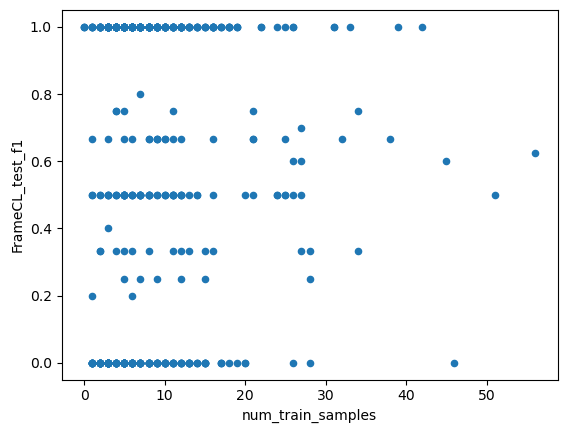

In [383]:
sort_frameCL_f1.plot.scatter("num_train_samples", "FrameCL_test_f1")

In [385]:

sort_frameCL_f1.loc[:,"FrameCL_test_f1"]

270    1.0
269    1.0
311    1.0
309    1.0
308    1.0
      ... 
342    0.0
343    0.0
344    0.0
345    0.0
95     0.0
Name: FrameCL_test_f1, Length: 541, dtype: float64

[Text(0, 0.5, 'Frequency'), Text(0.5, 0, 'num_train_samples')]

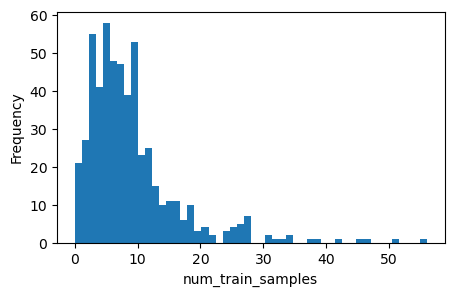

In [387]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'figure.figsize':(5,3), 'figure.dpi':100})

# Plot Histogram on x
plt.hist(sort_frameCL_f1.loc[:,"num_train_samples"], bins=50)
plt.gca().set(ylabel='Frequency', xlabel='num_train_samples')

In [394]:
print(f'Sum train samples of the frames covered by TEST set: {sort_frameCL_f1.loc[:,"num_train_samples"].sum()}')

Sum train samples of the frames covered by TEST set: 4831


##### ArgumentEX : 
Get Frame_name, input, output in the test set

In [307]:
from frame_semantic_transformer.data.LoaderDataCache import LoaderDataCache
from frame_semantic_transformer.data.tasks_from_annotated_sentences import tasks_from_annotated_sentences

import pandas as pd

tl = SwedishTrainingLoader('./swefn.xml')
il = SwedishInferenceLoader('./swefn.xml')
lc = LoaderDataCache(il)

samples = tasks_from_annotated_sentences(tl.load_test_data(), lc)       

# to store Frame_name of each test sample 

df_test_triggID = pd.DataFrame(
    [s.get_target(),
     s.get_input(),
     ] for s in samples if s.get_task_name() == "trigger_identification" )

df_test_triggID.columns= ["Trigger_word", "FrameCL_input", "Predict_loc", "Target_loc"]
df_test_triggID.head()

,Frame,FrameCL_input
0,En 32-årig man * låtsades vara cp-skadad för a...,TRIGGER: En 32-årig man låtsades vara cp-skada...
1,"2,5 år är inte särskilt lång * tid, säger hon.","TRIGGER: 2,5 år är inte särskilt lång tid , sä..."
2,Jag * stammade plågsamt mycket i 5-årsåldern.,TRIGGER: Jag stammade plågsamt mycket i 5-årså...
3,Pojke och tös är * antonymer eftersom de har u...,TRIGGER: Pojke och tös är antonymer eftersom d...
4,I dag är det bara att * glädja sig åt inrättan...,TRIGGER: I dag är det bara att glädja sig åt i...
